In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
#import src.cleaning as cl

***src***

In [3]:
def downloading(path):
    """This function downloads from a raw link and saves the dataframe locally.
    args:
    :url: string. the link
    :name: string. name to save the file
    """
    
    df=pd.read_csv(path, encoding='latin')
    
    return df

In [4]:
df = downloading('data/attacks.csv')
df.sample()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
23389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
def basic_cleaning(df):
    """This function modifies all words to lowercase, modifies the spaces in the column titles (replaces spaces with "_"),
    removes all rows with all NaN values, and removes duplicates.
    args: df
    return: df. cleaned df
    """
    
    #modifies all words to lowercase
    df=df.applymap(lambda x: x.lower() if type(x) == str else x)
    #modifies the spaces in the column titles (replaces spaces with "_"
    df.columns = [i.lower().replace(" ", "_") for i in df.columns]
    #drops all rows from DataFrame "df" that contain all missing values (NaN)
    df = df.dropna(how='all')
    #removes duplicates
    df= df.drop_duplicates()
    
    return df


In [6]:
df = basic_cleaning(df)
df.sample()

,case_number,date,year,type,country,area,location,activity,name,sex_,...,species_,investigator_or_source,pdf,href_formula,href,case_number.1,case_number.2,original_order,unnamed:_22,unnamed:_23
5971,1862.06.03,03-jun-1862,1862.0,unprovoked,south africa,kwazulu-natal,durban harbor,NaN,male,m,...,NaN,"cape argus, 6/10/1862; m. levine, gsaf",1862.06.03-male_durban_harbour.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,1862.06.03,1862.06.03,332.0,NaN,NaN


In [7]:
def cleaning_df1(df):
    """This function #remove the indicated columns from the df, creates a copy of the species_ column called species2,
    remove all rows from the indicated columns with duplicates, drops all rows from df that contain all missing values (NaN)
    in the specified subset of columns ('type', 'fatal_(y/n)', 'species2') and modifies the DataFrame in place. And renames some columns.
    args: df
    return: df. cleaned df
    """
    
    #remove the indicated columns from the df
    df.drop(['case_number', 'date', 'year', 'area', 'location', 'activity', 'name','investigator_or_source','pdf','href_formula', 'href', 'case_number.1', 'case_number.2', 'unnamed:_22','unnamed:_23' ], axis=1, inplace=True)
    #create a copy of the species_ column called species2
    df['species2']=df['species_'].copy()
    #remove all rows from the indicated columns with duplicates.
    df.drop_duplicates() 
    #drops all rows from df that contain all missing values (NaN) in the specified subset of columns ('type', 'fatal_(y/n)', 'species2') and modifies the DataFrame in place.
    df.dropna(subset=['type', 'fatal_(y/n)', 'species2'], how='all', inplace=True)
    #rename some columns
    df.rename(columns={'species_': 'species', 'fatal_(y/n)':'fatality', 'sex_' : 'sex'}, inplace=True)
    
    return df

In [8]:
df =  cleaning_df1(df)
df.sample()

,type,country,sex,age,injury,fatality,time,species,original_order,species2
5711,unprovoked,south africa,m,NaN,"fatal, leg bitten, foot partly severed",y,15h30,NaN,592.0,NaN


In [9]:
def cleaning_df2(df):
    """This function rops all rows from df that contain all missing values (NaN) in the specified subset of column ('species2')
    and modifies the DataFrame in place. It searches on the column ('species2')for any numeric character (\d) followed by an optional character (.) and 
    removes it, as well as deletes anything that's not a letter.
    args: df
    return: df. cleaned df
    """
    #drops all rows from df that contain all missing values (NaN) in the specified subset of column ('species2') and modifies the DataFrame in place.
    df.dropna(subset=['species2'], how='all', inplace=True)
    
    #It searches for any numeric character (\d) followed by an optional character (.) and removes it
    df['species2']=df['species2'].apply(lambda x: re.sub(r'\d.?', '', x, flags=re.IGNORECASE))
    
    #deletes anything that's not a letter
    df['species2'] = df['species2'].apply(lambda x: re.sub(r'\W+', ' ', x))
    
    return df 

In [10]:
df = cleaning_df2(df)
df.sample()

,type,country,sex,age,injury,fatality,time,species,original_order,species2
3916,unprovoked,north pacific ocean,m,33,right elbow bitten,n,15h30,"grey reef shark, 1.8 m [6'] grey reef shark, i...",2387.0,grey reef shark m grey reef shark identified b...


In [11]:
def species_cleaning(df):
    """This function modifies column species2, removes the letters 'm' and 'a' if they are found out of words,
    drops rows from df where the value in the 'species2' column is equal to any string in the "not_involved" list, 
    creates a dictionary with the species types and the values they appear with in the dataset, Iterates over each element
    of the species2 column of the dataframe and replace the values for the keys, and keeps only the words with more than two
    characters and then joins them back together with spaces
    args: df
    return: df. cleaned df
    """
    
    #removes the letters 'm' and 'a' if they are found out of words.
    df['species2'] = df['species2'].str.replace(r'\s[m|a]\s', ' ', regex=True)
    df['species2'] = df['species2'].str.replace(r'^m|a\s', '', regex=True)
    df['species2'] = df['species2'].str.replace(r'\sm|as$', '', regex=True)
    
    #drops rows from df where the value in the 'species2' column is equal to any string in the "not_involved" list.
    not_involved= ['Shark involvement prior to death unconfirmed', 'shark involvement not confirmed', 'shark involvement no t confirmed', 'Shark involvement prior to death not confirmed', 'Shark involvement suspected but not confirmed', 'Invalid', 'shark involvement not confirmed']
    for case in not_involved:
        df.drop(df[df['species2'] == case].index)
    
    #create a dictionary with the species types and the values they appear with in the dataset
    species_dict={'white shark': 'white shark|whites', 
                  'nurse shark': 'nurse|nurses',
                  'tiger shark': 'tiger|tigers',
                  'grey reef shark': 'grey|greys|gray',
                  'wobbegong shark':'wobbegong|wobbegongs',
                  'bull shark': 'bull|bulls|zambezi|zambesi',
                  'blacktip shark': 'blacktip|blacktips|black tipped',
                  'hammerhead shark': 'hammerhead|hammerheads', 
                  'mako shark': 'Mako|Makos|ako|Akos',
                  'lemon shark': 'lemon|lemons',
                  'largeako shark': 'largeako|largeakos', 
                  'oceanic whitetip shark': 'oceanic whitetip|oceanic whitetips', 
                  'whitetip reef shark':'whtietip|white tipped|whitetip reef',
                  'bronze whaler shark': 'bronze whaler|bronze whalers|bronze whale|Copper', 
                  'spinner shark': 'spinner|spinners',                 
                  'caribbean reef shark' : 'caribbean reef|caribbean reefs',                  
                  'blue shark' : 'blue pointer|blue pointers|blue shark|blue sharks|blue nose', 
                  'sandbar shark': 'brown|brown sharks|sand|sandbar',
                  'raggedtooth shark': 'raggedtooth',
                  'dog fish shark': 'dog|dogfish',                
                  'unidentified shark' : 'unidentified|unknown',
                  'small shark' : 'small shark|small sharks'
                 }
    
    # Iterate over each element of the species2 column of the dataframe and replace the values for the keys
    for key, value in species_dict.items():
        mask= df['species2'].str.contains(value, case=False)
        df.loc[mask, 'species2'] = key

    #modify the cells where a species appears.
    for specie, word in species_dict.items():   
        df.loc[df['species2'].str.contains(word, case=False), 'species2'] = specie
    
    #keeps only the words with more than two characters and then joins them back together with spaces
    df['species2'] = df['species2'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))
    
    return df

In [12]:
df = species_cleaning(df)
df.sample()

,type,country,sex,age,injury,fatality,time,species,original_order,species2
1906,invalid,usa,f,NaN,left hand injured,n,NaN,shark involvement not confirmed,4397.0,shark involvement not confirmed


In [13]:
def type_species_cleaning(df):
    """This function drops rows from df where the value in the 'type' column is equal to 'invalid', and modifies the df.
    eliminate rows with species2 column with Nan, removes the unique values that have less than 6 elements on the species2
    column in df, remove those unique values that are not shark species. drops age and time columns from the df.
    args: df
    return: df. cleaned df
    """
    
    #drops rows from df where the value in the 'type' column is equal to 'invalid', and modifies the df.
    df.drop(df[df['type'] =='invalid'].index, inplace=True)
    
    #eliminate rows with species2 column with Nan 
    df.dropna(subset=['species2'], how='all', inplace=True)
    
    #remove the unique values that have less than 6 elements on the species2 column in df
    species_counts= {}
    for i,x in df['species2'].value_counts().items():
        species_counts[i]=x
        
    new_dict = {}
        
    for key, value in species_counts.items():
        if type(value) == int:
            if value >= 6:
                new_dict[key] = value

    
    #remove those unique values that are not shark species
    species_list = list(new_dict.keys())
    species_list.remove('shark')
    species_list.remove('')
    species_list.remove('sharks')
    species_list.remove('small shark')
    species_list.remove('unidentified shark')
    species_list.remove('shark involvement not confirmed')
    
    df = df[df['species2'].isin(species_list)]
    
    #drops age and time columns from the df
    df.drop(['age', 'time'], axis=1, inplace=True)

    return df

In [14]:
df = type_species_cleaning(df)
df.sample()

C:\Users\pagob\AppData\Local\Temp\ipykernel_10424\2774136200.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['age', 'time'], axis=1, inplace=True)


,type,country,sex,injury,fatality,species,original_order,species2
2686,unprovoked,usa,m,forearm bitten,n,white shark,3617.0,white shark


In [15]:
species_counts= {}
for i,x in df['species2'].value_counts().items():
    species_counts[i]=x
        
print(species_counts) 

{'white shark': 628, 'tiger shark': 283, 'bull shark': 208, 'blacktip shark': 104, 'nurse shark': 97, 'bronze whaler shark': 69, 'mako shark': 53, 'blue shark': 52, 'wobbegong shark': 49, 'hammerhead shark': 48, 'raggedtooth shark': 43, 'lemon shark': 34, 'sandbar shark': 30, 'grey reef shark': 29, 'oceanic whitetip shark': 24, 'spinner shark': 21, 'caribbean reef shark': 16, 'reef shark': 13, 'dog fish shark': 10, 'sevengill shark': 9, 'whitetip reef shark': 7, 'dusky shark': 7, 'basking shark': 7, 'carpet shark': 7, 'angel shark': 6, 'galapagos shark': 6}


In [16]:
def fatality_sex_cleaning(df):
    """This function modifies specified data in the fatality column an Replaces words in the selected rows.
    args: df
    return: df. cleaned df
    """
    #modify the data in the fatality column
    mask_unknown = (df['fatality'] == '2017')
    
    #Replace the words in the selected rows
    df.loc[mask_unknown, 'fatality'] = 'unknown'
    
    #modify the data in the fatality column
    mask_no = (df['fatality'] == ' n')
    
    #Replace the words in the selected rows
    df.loc[mask_no, 'fatality'] = 'n'
    
    #modify the data in the fatality columny
    mask_unknown2 = (df['fatality'] == 'm')
    
    #Replace the words in the selected rows
    df.loc[mask_unknown2, 'fatality'] = 'unknown'
    
    df['sex']=df['sex'].str.replace(r'm\s', 'm', regex=True)
    df['sex']=df['sex'].str.replace(r'n', 'unknown', regex=True)
    df['sex']=df['sex'].str.replace(r'lli', 'unknown', regex=True)
    
    return df

In [17]:
df = fatality_sex_cleaning(df)
df.sample()

,type,country,sex,injury,fatality,species,original_order,species2
4842,unprovoked,australia,m,"head, neck & shoulder bitten (in 1918, he was ...",n,"tiger shark, 9' to 10'",1461.0,tiger shark


In [18]:
def visualization_cleaning(df):
    """This function modifies specified data in the fatality column an Replaces words in the selected rows to yes or no.
    args: df
    return: df. cleaned df
    """
    
    #create a df with the variables species, sex, and fatality
    df = df.loc[:, ['species2', 'fatality','sex']]
    df.rename(columns={'species2': 'species'}, inplace=True)
    
    
    #modify the data in the fatality column to yes or no
    no_fatality = (df['fatality'] == 'n')
    df.loc[no_fatality, 'fatality'] = "no"
    
    yes_fatality = (df['fatality'] == 'y')
    df.loc[yes_fatality, 'fatality'] = "yes"
    
    
    return df

In [19]:
df = visualization_cleaning(df)
df.sample()

,species,fatality,sex
5434,white shark,yes,f


In [20]:
def seaborn_set():
    sns.set_context("poster")
    sns.set(rc={"figure.figsize": (15.,12.)})
    sns.set_style("whitegrid")

In [21]:
seaborn_set()

In [22]:
def species_vs_total_attacks(df):
    """This function Creates a countplot with species column in ascending order and with deep palette, Rotate x-axis 
    tick labels for better readability and modifies title, xlabel and ylabel. Finally it saves the plot as an image 
    called: species_vs_total_attacks
    args:
    -df: pandas DataFrame containing the shark attack data
    returns:
    -None
    """
    
    # Creates a countplot with species column in ascending order and with deep palette
    sns.countplot(y=df['species'], order=df['species'].value_counts(ascending=True).index, palette='deep')
    
    # Rotate x-axis tick labels for better readability and modifies title, xlabel and ylabel.
    plt.xticks(rotation=90)
    plt.title('26 shark species vs 1.860 attacks')
    plt.ylabel('Shark species', weight='bold')
    plt.xlabel('Number of attacks', weight='bold')
    
    # Save the plot as an image and display the plot
    plt.savefig('figures/species_vs_total_attacks.png')
    os.system("start figures/species_vs_total_attacks.png")
    plt.show()


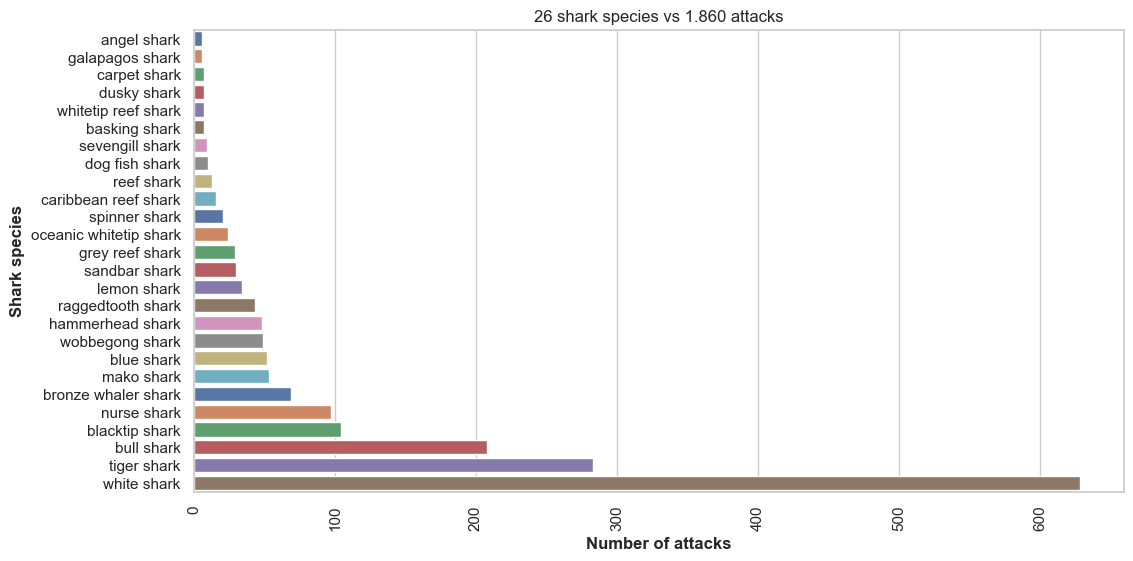

In [23]:
species_vs_total_attacks(df)

In [24]:
def species_vs_attacks_pie(df):
    """This function Creates a pieplot with species column, Sum the counts of all species that make up less than 10% 
    of the total, Group these species into a new category called "Other" and save the plot as an image and display the plot.
    args:
    -df: pandas DataFrame containing the shark attack data
    returns:
    -None
    """
    sharks = df["species"].value_counts()
    # Sum the counts of all species that make up less than 10% of the total
    other_count = sharks[sharks/sum(sharks) < 0.04].sum()
    # Group these species into a new category called "Other"
    sharks = sharks[sharks/sum(sharks) >= 0.04]
    sharks["Other"] = other_count
    # Plot the pie chart
    
    sharks.index = sharks.index.str.capitalize()
    pie = sharks.plot.pie(autopct="%.1f%%", textprops={'color': 'black', 'fontsize': 10, 'va': 'center'})
    
    plt.title('Shark species vs number of attacks')
    # Save the plot as an image and display the plot
    plt.savefig('figures/species_vs_attacks_pie.png')
    os.system("start figures/species_vs_attacks_pie.png")
    plt.show()  


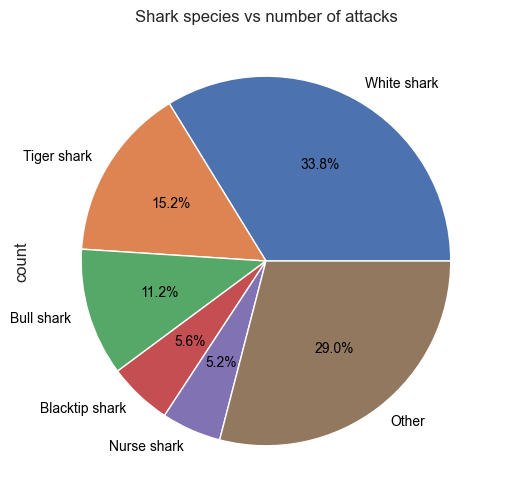

In [25]:
species_vs_attacks_pie(df)

In [26]:
def species_vs_fatality(df):
    """This function Creates a histplot with species column, Sum the counts of all species that attacked people with a fatal result.
    args:
    -df: pandas DataFrame containing the shark attack data
    returns:
    -None
    """
    df_filter = df.query('fatality in "yes"')
    sns.histplot(data=df_filter, x="species", hue="fatality", multiple="stack");
    plt.xticks(rotation=90);
    plt.title('Shark species vs number of fatalities')
    plt.xlabel('shark species')
    plt.ylabel('Fatal attacks');
    
    # Save the plot as an image and display the plot
    plt.savefig('figures/species_vs_fatality.png')
    os.system("start figures/species_vs_fatality.png")
    plt.show()

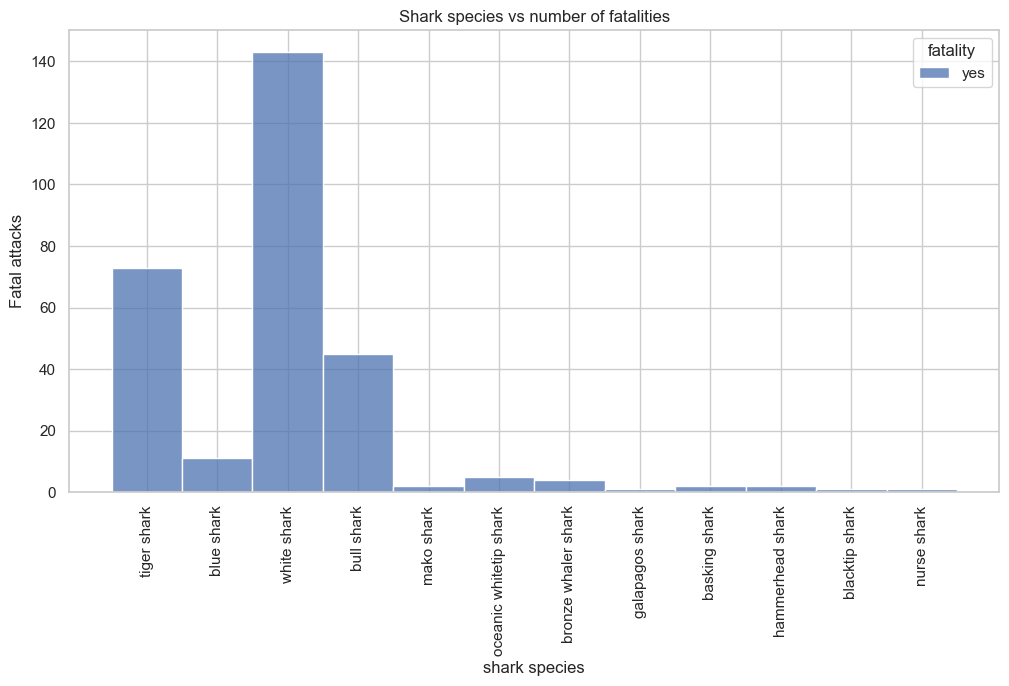

In [27]:
species_vs_fatality(df)

In [28]:
def species_vs_attacks_fatality(df):
    """This function Creates a histplot with species column, Sum the counts of all species that attacked people and if the result
    was a fatality or not.
    args:
    -df: pandas DataFrame containing the shark attack data
    returns:
    -None
    """
    
    df_filtered1 = df.query('fatality in ["yes", "no"]')
    sns.histplot(data=df_filtered1, x="species", hue="fatality", multiple="stack");
    plt.xticks(rotation=90);
    plt.title('Shark species vs number of attacks and fatality')
    plt.xlabel('shark species')
    plt.ylabel('attacks');
    
    # Save the plot as an image and display the plot
    plt.savefig('figures/species_vs_attacks_fatality.png')
    os.system("start figures/species_vs_attacks_fatality.png")
    plt.show()

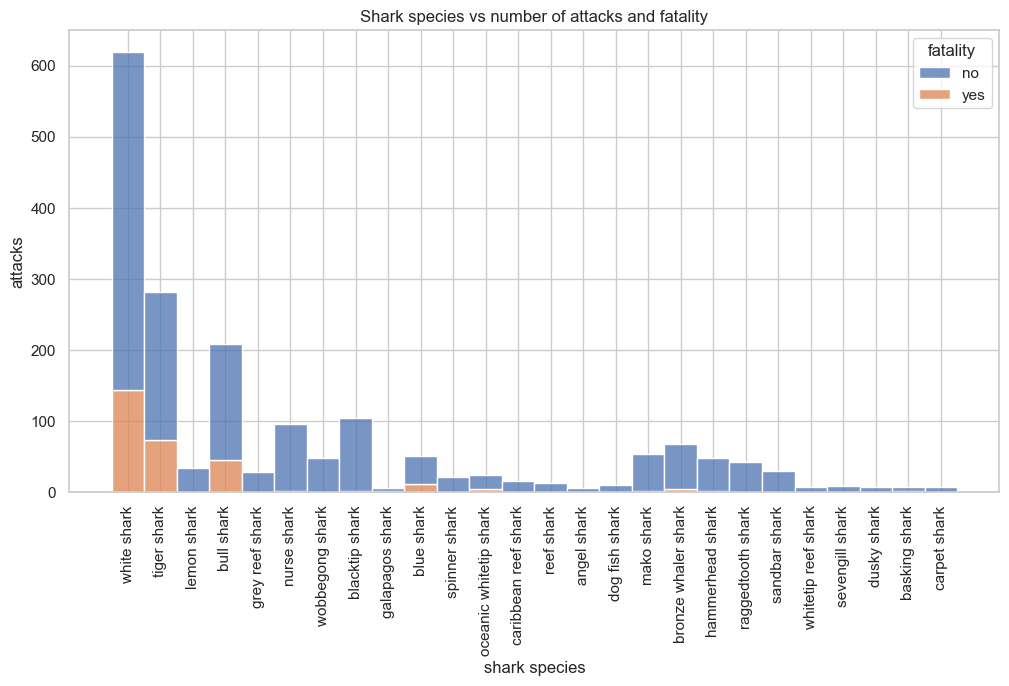

In [29]:
species_vs_attacks_fatality(df)

In [30]:
def fatality_sex(df):
    """This function Creates a histplot with the sum of all the attacked people, their sex and if the result was a fatality or not.
    args:
    -df: pandas DataFrame containing the shark attack data
    returns:
    -None
    """
    
    #Filter the data to include only "yes" or "no" in the "fatality" column and "m" or "f" in the "sex" column"
    df_filtered = df.query('fatality in ["yes", "no"] and sex in ["m", "f"] and fatality != "unknown"')
    #create the plot
    sns.histplot(data=df_filtered, x="sex", hue="fatality", multiple="stack")
    plt.title('Fatality vs Attacked person sex')
    plt.xlabel('Sex')
    plt.ylabel('Shark attacks');
    
    # Save the plot as an image and display the plot
    plt.savefig('figures/fatality_sex.png')
    os.system("start figures/fatality_sex.png")
    plt.show()

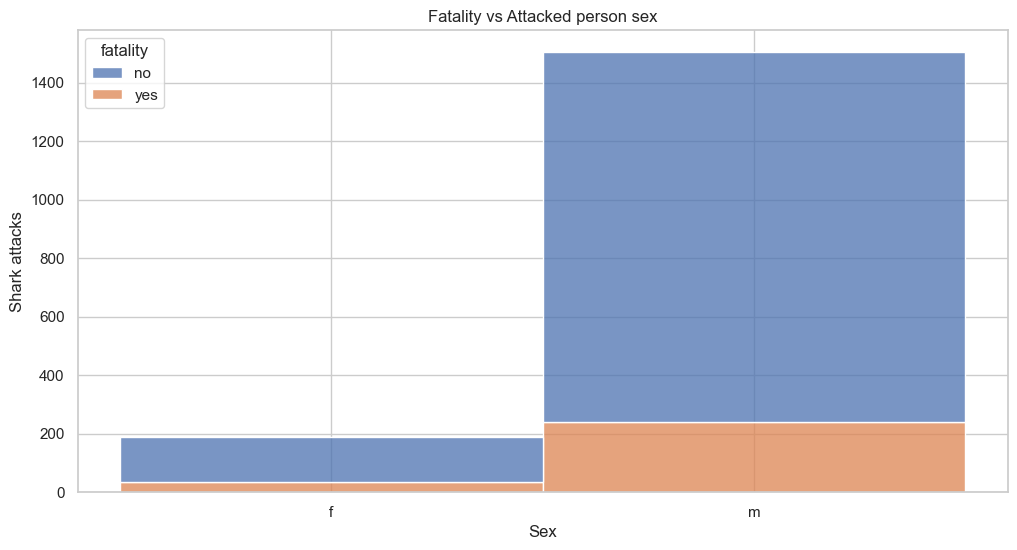

In [31]:
fatality_sex(df)